In [11]:
from functools import lru_cache
from typing import List, Any, Tuple

def shortest_common_supersequence(
    seqs: List[List[Any]]
) -> Tuple[List[Any], List[List[int]]]:
    """
    Returns (scs, idx_lists) where
      - scs is a shortest common supersequence of the input `seqs`
      - idx_lists[i] is the list of sequence-indices that contributed
        the element scs[i] (i.e. were advanced) at that position.
    """
    k = len(seqs)
    lengths = tuple(len(s) for s in seqs)

    @lru_cache(None)
    def dp(pos: Tuple[int, ...]) -> Tuple[Tuple[Any, ...], Tuple[Tuple[int, ...], ...]]:
        # If all sequences are fully consumed, no more symbols or indices
        if pos == lengths:
            return (), ()

        # all next‐possible symbols
        candidates = {
            seqs[i][pos[i]]
            for i in range(k)
            if pos[i] < lengths[i]
        }

        best_seq: Tuple[Any, ...] = ()
        best_idxs: Tuple[Tuple[int, ...], ...] = ()
        first = True

        for e in candidates:
            # compute how far we advance in each sequence if we pick e
            new_pos = list(pos)
            advanced = []
            for i in range(k):
                if new_pos[i] < lengths[i] and seqs[i][new_pos[i]] == e:
                    new_pos[i] += 1
                    advanced.append(i)
            new_pos = tuple(new_pos)

            # recurse
            suffix_seq, suffix_idxs = dp(new_pos)

            cand_seq = (e,)+suffix_seq
            cand_idxs = (tuple(advanced),)+suffix_idxs

            if first or len(cand_seq) < len(best_seq):
                best_seq, best_idxs = cand_seq, cand_idxs
                first = False

        return best_seq, best_idxs

    scs_tuple, idxs_tuple = dp(tuple([0]*k))
    # convert to lists
    scs = list(scs_tuple)
    idx_lists = [list(tup) for tup in idxs_tuple]
    return scs, idx_lists





if __name__ == "__main__":
    # 10 example stacks, each length 5
    stacks = [
        [1, 2, 3, 5],
        [5, 4, 3, 2, 1],
        [2, 2, 3, 2],
        [7, 8, 7, 8, 7],
        [1, 3, 5, 3, 1],
        [9, 1, 2],
        [4, 4],
        [2, 5, 8, 5, 2, 1, 7],
        [1, 6, 8, 3, 9],
        [3, 1, 4, 3],
    ]

    seq, ann = shortest_common_supersequence(stacks)
    print(f"Min pops = {len(seq)}")
    
    for step, (d, pops) in enumerate(zip(seq, ann), 1):
        print(f"{step:3d}: pop {d}  → stacks {pops}")
        
    print(i for i in zip(seq, ann))


Min pops = 19
  1: pop 1  → stacks [0, 4, 8]
  2: pop 2  → stacks [0, 2, 7]
  3: pop 2  → stacks [2]
  4: pop 4  → stacks [6]
  5: pop 5  → stacks [1, 7]
  6: pop 6  → stacks [8]
  7: pop 7  → stacks [3]
  8: pop 8  → stacks [3, 7, 8]
  9: pop 3  → stacks [0, 2, 4, 8, 9]
 10: pop 5  → stacks [0, 4, 7]
 11: pop 7  → stacks [3]
 12: pop 8  → stacks [3]
 13: pop 9  → stacks [5, 8]
 14: pop 1  → stacks [5, 9]
 15: pop 4  → stacks [1, 6, 9]
 16: pop 3  → stacks [1, 4, 9]
 17: pop 2  → stacks [1, 2, 5, 7]
 18: pop 1  → stacks [1, 4, 7]
 19: pop 7  → stacks [3, 7]
<generator object <genexpr> at 0x7613b3e2ca00>


In [6]:
import numpy as np
import pandas as pd
import genetic_algorithm.population as population

pop = population.generate_random_forest(5)

In [7]:
import genetic_algorithm.transforms as transforms
data = pd.read_csv("../data/ES15.csv")
x_raw = data.values

In [8]:
x_gen = transforms.forest2features(
    population=pop,
    x_raw=x_raw
)

0    float64
1    float64
2    float64
3    float64
4    float64
dtype: object


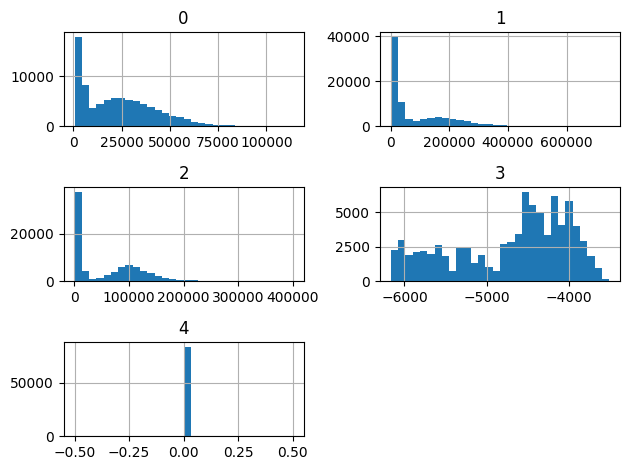

In [9]:
import matplotlib.pyplot as plt
x = pd.DataFrame(x_gen)
print(x.dtypes)
x.hist(bins=30)
plt.tight_layout()
plt.show()